## Part 1

In [29]:
# Import the dataset
import pandas as pd

mydata = pd.read_csv('amazon_reviews.csv')
mydata.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [30]:
# a)

import numpy as np

# summary length
summary_list = mydata['Summary'].tolist()
s_length = [len(str(s)) for s in summary_list] 
# There are some entries of type float, so str() is used 

s_length = np.array(s_length) # a numpy array of length values
s_min = np.amin(s_length)
s_avg = round(np.mean(s_length)) # non-integer length doesn't make sense
s_med = np.median(s_length)
s_max = np.amax(s_length)


# text length
text_list = mydata['Text'].tolist()
t_length = [len(str(t)) for t in text_list] 
t_length = np.array(t_length) 
t_min = np.amin(t_length)
t_avg = round(np.mean(t_length))
t_med = np.median(t_length)
t_max = np.amax(t_length)


# score
score_array = mydata['Score'].to_numpy()
sc_min = np.amin(score_array)
sc_avg = round(np.mean(score_array),1) # Amazon uses 1 decimal place
sc_med = np.median(score_array)
sc_max = np.amax(score_array)


# helpfulness ratio 
#df = mydata.loc[mydata['HelpfulnessDenominator'] != 0]
#df = df.reset_index()
df = mydata
numerator = df['HelpfulnessNumerator'].to_numpy() 
denominator = df['HelpfulnessDenominator'].to_numpy() 

## There are two cases where numerator is greater than denominator (3/2 and 3/1). They are dropped
drop_index = []
for i in range(len(df)):
    if numerator[i]>denominator[i]:
        drop_index.append(i)
df = df.drop(labels=drop_index, axis=0)
df = df.reset_index()

numerator = df['HelpfulnessNumerator'].to_numpy() 
denominator = df['HelpfulnessDenominator'].to_numpy() 
# data with 0 as denominator (270052 entries) will have a ratio of 0
ratio = np.divide(numerator,denominator, out=np.zeros(len(df)), where=denominator!=0) # element-wise division
# there are 303826 entries with 0 ratio values
r_min = np.amin(ratio)
r_avg = round(np.mean(ratio),2)
r_med = np.median(ratio)
r_max = np.amax(ratio)


# Table (a pandas data frame)
d = {'SummaryLength':[s_min,s_avg,s_med,s_max], 'TextLength':[t_min,t_avg,t_med,t_max], 
    'Score':[sc_min,sc_avg,sc_med,sc_max], 'HelpfulnessRatio':[r_min,r_avg,r_med,r_max]}
table = pd.DataFrame(data=d, index=['Minimum','Average','Median','Maximum'])
table

,SummaryLength,TextLength,Score,HelpfulnessRatio
Minimum,1.0,12.0,1.0,0.00
Average,23.0,436.0,4.2,0.41
Median,20.0,302.0,5.0,0.00
Maximum,128.0,21409.0,5.0,1.00


In [31]:
# b)

# Add summary length, text length as two new columns; 
# drop those two cases and add ratio as another new column;
# sort the dataframe based on the column 'Time' in ascending order
df_sorted = mydata 
df_sorted['SummaryLength'] = s_length
df_sorted['TextLength'] = t_length
df_sorted = df_sorted.drop(labels=drop_index, axis=0)
df_sorted = df_sorted.reset_index()
df_sorted['HelpfulnessRatio'] = ratio
df_sorted = df_sorted.sort_values(by='Time')
df_sorted = df_sorted.reset_index()

# convert seconds from first sec of 1970 to pandas datetime format, 
# then add them as a new column to the data frame
date = []
for i in range(len(df_sorted)):
    date.append(pd.Timestamp(df_sorted['Time'][i], unit='s'))
df_sorted['Date'] = date

# group by date and compute mean of summary length, text length, score, and ratio
df_grouped = df_sorted.groupby(df_sorted['Date']).agg({'SummaryLength': ['mean'], 'TextLength':['mean'],
                                            'Score':['mean'], 'HelpfulnessRatio':['mean']})

Text(0, 0.5, 'Avg. Helpfulness Ratio')

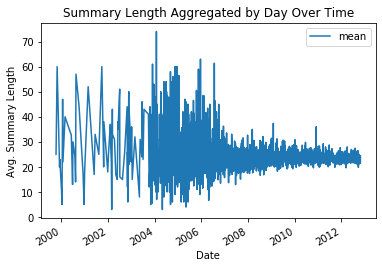

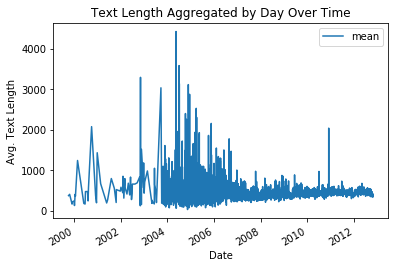

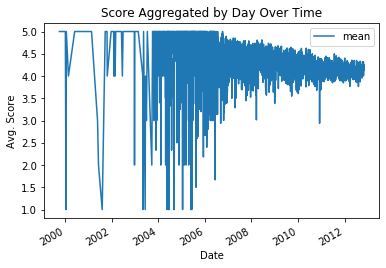

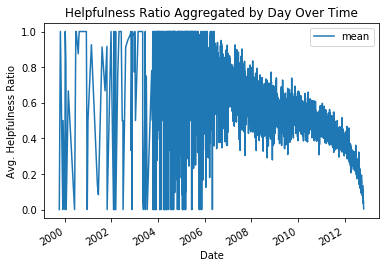

In [32]:
# graphs
import matplotlib.pyplot as plt

df_grouped['SummaryLength'].plot(title='Summary Length Aggregated by Day Over Time')
plt.ylabel('Avg. Summary Length')

df_grouped['TextLength'].plot(title='Text Length Aggregated by Day Over Time')
plt.ylabel('Avg. Text Length')

df_grouped['Score'].plot(title='Score Aggregated by Day Over Time')
plt.ylabel('Avg. Score')

df_grouped['HelpfulnessRatio'].plot(title='Helpfulness Ratio Aggregated by Day Over Time')
plt.ylabel('Avg. Helpfulness Ratio')

In [ ]:
# c) LDA
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
import re

# Remove punctuation
mydata['Text_processed'] = mydata['Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert all text to lowercase
mydata['Text_processed'] = mydata['Text_processed'].map(lambda x: x.lower())

mydata['Text_processed'].head()

In [34]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(mydata['Text_processed'])

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Set number of topics to 5 
number_topics = 5

# the LDA model - I have saved the model to my pc. Please uncomment if you want to train the model
#lda = LDA(n_components=number_topics, n_jobs=-1)
#lda.fit(count_data)

# Save the model for future use
from joblib import dump, load
#dump(lda, 'mylda.joblib') 

# Helper function to print the result
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
         
lda = load('mylda.joblib')

# set number of top words to show from each topic to 20
number_words = 20
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
br like taste good flavor great just chocolate love sugar really eat sweet snack product don make little free chips

Topic #1:
br food dog cat cats dogs eat like product treats chicken ingredients good just diet foods love healthy dry day

Topic #2:
coffee br tea like taste flavor cup good drink just great water love cups strong really tried green ve use

Topic #3:
br amazon product price great good order buy store box time ordered just shipping local bought love best bag stores

Topic #4:
br like just product use great time water little love dog good loves really oil don treats treat popcorn old


In [ ]:
# I will train a new lda model along with some visuals after lemmatizing and cleaning the review text

# 5 Topics here: 
# some sweet snack; 
# some dog/cat food ; 
# some coffee/tea; 
# shopping experience; 
# some (dog) treats

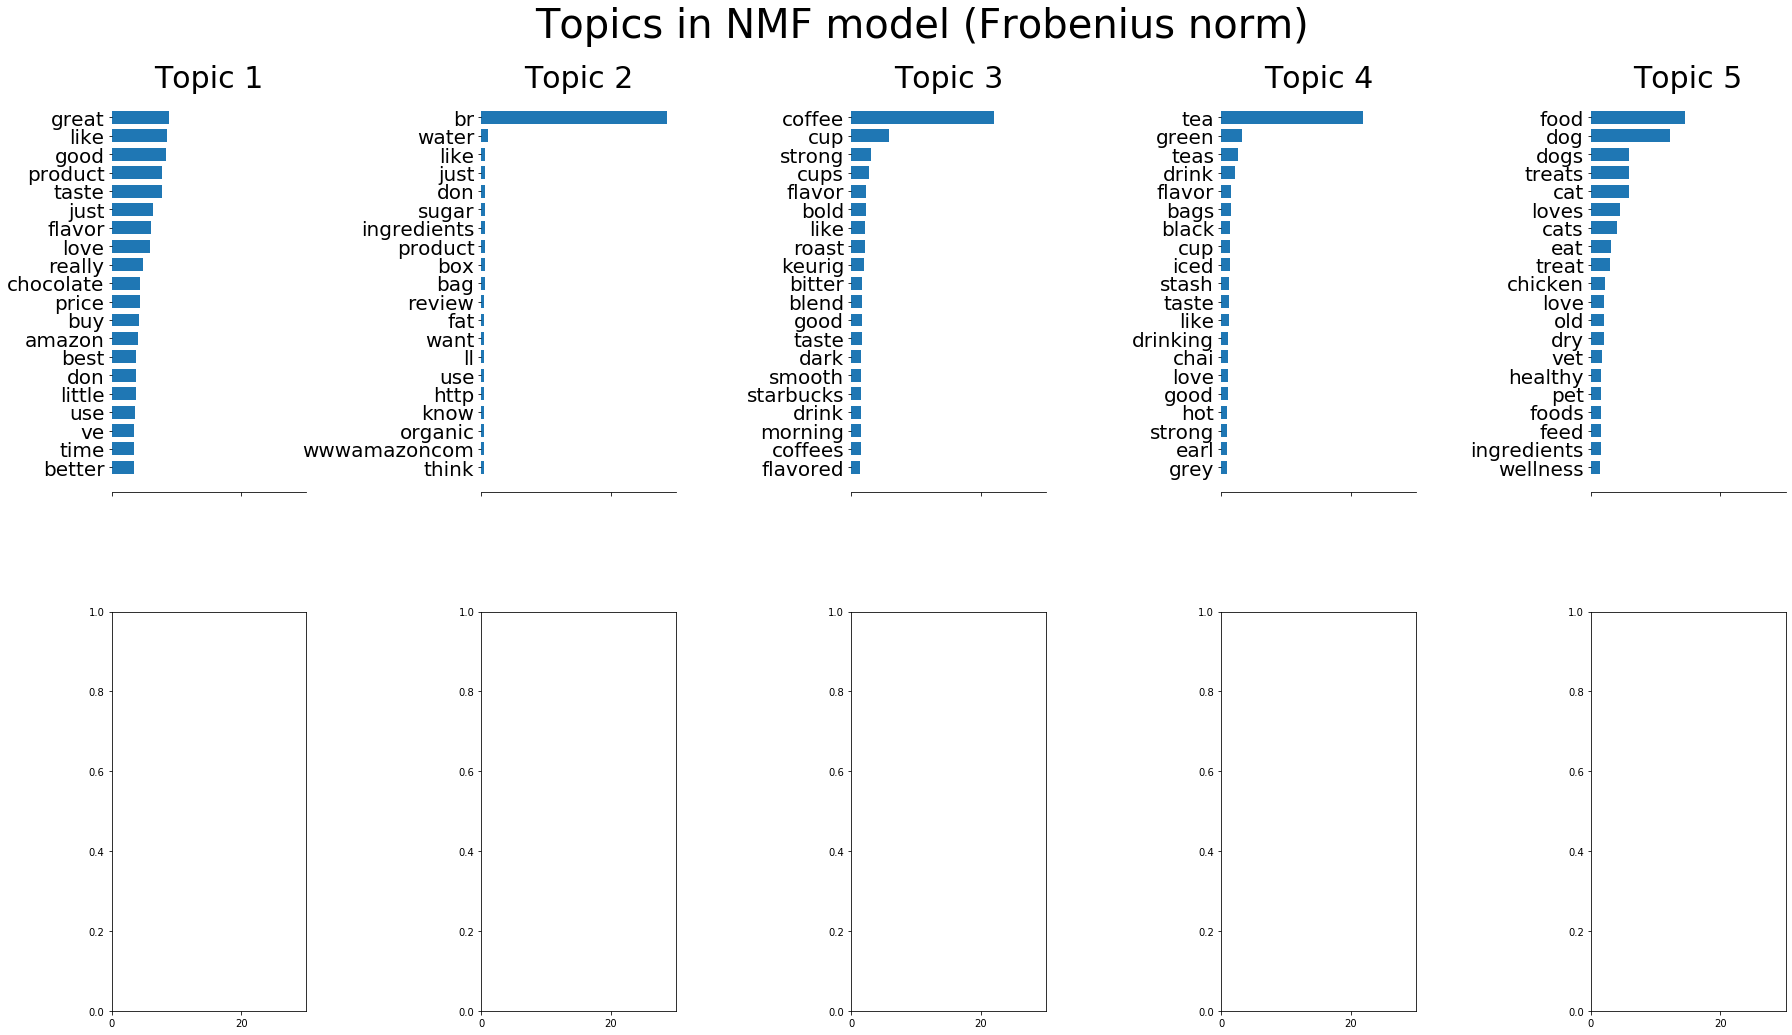

In [35]:
# d) NMF (set to 5 topics)

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

n_features = 1000
n_components = 5
n_top_words = 20

def plot_top_words(model, feature_names, n_top_words, title):
    # a function to plot the top words for each topic
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# vectorization. Common English words, words occurring in
# only one document or in at least 95% of the documents are removed.
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(mydata['Text_processed'])

# Fit the NMF model - please uncomment if you want to train the model
#nmf = NMF(n_components=n_components, random_state=1,
          #alpha=.1, l1_ratio=.5).fit(tfidf)

nmf = load('mynmf.joblib')
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# save the model
#from joblib import dump, load
#dump(nmf, 'mynmf.joblib') 


# The coffee, tea, and dog food topics are similar to the previous result, but topic 1 seems like some mixture of topics from the previous result.
# Also, I think topic 2 can be discarded as it does not make sense.

In [ ]:
# e) 

#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
#import re
#import emoji

# use the functions defined in file "lemmatizer"
## I keep getting errors when using the orignal code provided in 'lemmatizer.py', so I modified the code based on my own understanding
from lemmatizer import *

summary_clean = []
text_clean = []
summary_no_na = mydata['Summary'].fillna('') # there are some nan values in summary column
for i in range(len(mydata)):
    summary_clean.append(lemmatize_text(summary_no_na[i])) 
    text_clean.append(lemmatize_text(mydata['Text'][i]))
mydata['Summary_clean'] = summary_clean
mydata['Text_clean'] = text_clean
mydata.head()

In [ ]:
# save the df with new columns added
mydata.to_pickle("mydata_clean.pkl")

In [36]:
# f)

# load the saved data frame with Summary_clean and Text_clean
mydata = pd.read_pickle("mydata_clean.pkl")

# cosine similarity
from cosine_similarity import *

cosine_score = []
for i in range(len(mydata)):
    cosine_score.append( get_cosine(text_to_vector(mydata['Summary_clean'][i]), text_to_vector(mydata['Text_clean'][i])) )

Text(0.5, 6.79999999999999, 'Cosine Similarity')

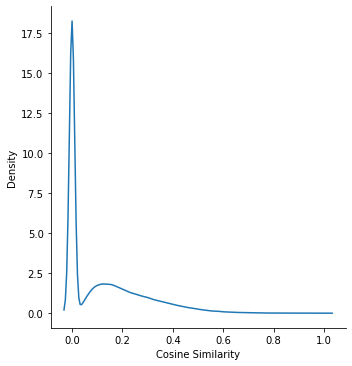

In [37]:
# density plot
import seaborn as sns  # seaborn 0.11.0
import matplotlib.pyplot as plt

sns.displot(cosine_score, kind='kde')
plt.xlabel('Cosine Similarity')

In [38]:
# large scores
print('Large scores:')
print()
for i in range(len(cosine_score)):
    if cosine_score[i] >= 0.9:
        print(i, cosine_score[i])
        
# how many scores are >= 0.5?
how_many = 0
for i in range(len(cosine_score)):
    if cosine_score[i] >= 0.5:
        how_many += 1
print()
print('Number of scores that are greater than 0.5:')
print(how_many)

# We can see from the density plot that the cosine similarity scores are mainly distributed around 0. There are several very large
# values (>=0.9) where summary is the same as text or the entire summary is a part of text. Moreover, there are only 13108 scores which are
# greater than or equal to 0.5, so I would say Summary_clean is not predictive of Text_clean.

Large scores:

477 0.9999999999999999
19394 0.9072647087265548
22449 1.0
26052 0.9999999999999999
28589 1.0
56568 0.9999999999999999
67790 0.9999999999999999
76866 1.0
78581 0.9999999999999999
78881 1.0
90381 1.0
112937 0.9999999999999999
122873 0.9045340337332909
148191 1.0000000000000002
156384 0.9704949588309457
163937 0.9534625892455924
193549 0.9999999999999999
202002 1.0
202760 1.0
222709 0.9999999999999998
228690 0.9999999999999999
233830 1.0
234053 1.0
234453 0.9341987329938275
256424 0.9629500128629352
276793 1.0
299708 0.9999999999999998
315312 1.0
331827 0.9999999999999999
339783 1.0
342703 0.9574271077563381
378831 0.9981867618808632
388904 1.0000000000000002
390652 0.9999999999999998
393899 0.9370425713316364
403266 0.9999999999999999
413256 1.0000000000000002
421771 0.9354143466934853
424554 0.9363291775690445
453668 1.0
460528 0.9428090415820635
466486 0.9999999999999999
483003 0.9231861823449954
497839 0.9999999999999999
512286 1.0
519296 1.0000000000000002
533503 1.0
5

## Part 2

In [39]:
# load the saved data frame with Summary_clean and Text_clean
mydata = pd.read_pickle("mydata_clean.pkl")

# Perform LDA again for cleaned text (set to 5 topics)
# Convert all text to lowercase
mydata['Text_clean_processed'] = mydata['Text_clean'].map(lambda x: x.lower())

from sklearn.feature_extraction.text import CountVectorizer

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed text
count_data = count_vectorizer.fit_transform(mydata['Text_clean_processed'])

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function to print the result
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Set number of topics to 5 
number_topics = 5

# the LDA model - uncomment if you want to train the model
#lda2 = LDA(n_components=number_topics, n_jobs=-1)
#lda2.fit(count_data)

# Save the model for future use
from joblib import dump, load
#dump(lda2, 'lda2.joblib') 

In [40]:
lda2 = load('lda2.joblib')

# set number of top words to show from each topic to 20
number_words = 20
print("Topics found via LDA:")
print_topics(lda2, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
food dog cat treat love like product eat good time year old day great chicken little really bag ingredient baby

Topic #1:
tea flavor like taste good make great love sauce hot use add really green ve mix tried little best time

Topic #2:
product water taste like oil use bottle salt sugar good drink coconut day popcorn time ingredient natural work used flavor

Topic #3:
coffee cup like flavor taste good drink great love strong tried make really blend roast best ve dark chocolate try

Topic #4:
good like product great taste amazon love chocolate price flavor box store bag snack bar buy free time eat order


In [41]:
# visualization
from pyLDAvis import sklearn as sklearn_lda
v = sklearn_lda.prepare(lda2, count_data, count_vectorizer)

import pyLDAvis
pyLDAvis.enable_notebook()
v

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.008447 -0.100698       1        1  30.910877
0      0.170901 -0.028145       2        1  18.287564
2      0.042481  0.128458       3        1  18.155901
1     -0.102995  0.015739       4        1  17.027697
3     -0.118835 -0.015355       5        1  15.617961, topic_info=            Term           Freq          Total Category  logprob  loglift
32169     coffee  171263.000000  171263.000000  Default  30.0000  30.0000
130131       tea  152061.000000  152061.000000  Default  29.0000  29.0000
44042        dog  104617.000000  104617.000000  Default  28.0000  28.0000
55290       food  146708.000000  146708.000000  Default  27.0000  27.0000
27296        cat   62660.000000   62660.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
136263       try   14496.599643   69108.667138   Topic5  -5.3572   0.2950
52380   favorite   13224.793264   44209.931959   Topic5  -5.4490   0.6499
103486     price   14245.139940   79364.262768   Topic5  -5.3747   0.1391
139513       use   13716.674562   83558.871311   Topic5  -5.4125   0.0498
19369     better   13137.959282   69920.566880   Topic5  -5.4556   0.1849

[449 rows x 6 columns], token_table=        Topic      Freq  Term
term                         
8255        2  0.000632  acid
8255        3  0.845241  acid
8255        5  0.153996  acid
8525        1  0.119831   add
8525        2  0.032801   add
...       ...       ...   ...
146859      1  0.276482  year
146859      2  0.332644  year
146859      3  0.124057  year
146859      4  0.168653  year
146859      5  0.098164  year

[1014 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4])

### 5 topics:
### some good tasting sweet snack; dog/cat food; some product and its ingredients; tea drink; coffee drink. 

In [ ]:
# Get the most probable topic for each review and add them as a new column
text_topic = lda2.transform(count_data)
topic = []
for n in range(text_topic.shape[0]):
    most_likely_topic = text_topic[n].argmax()
    topic.append(most_likely_topic+1)
mydata['Topic'] = topic

In [ ]:
# Save the dataframe
mydata.to_pickle("mydata_clean_lda.pkl")

In [ ]:
# Sentiment Analysis
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
mydata['CompoundScore'] = mydata['Text_clean_processed'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [ ]:
# Save the dataframe
mydata.to_pickle("mydata_clean_lda_sentiment.pkl")

### Model Creation

In [ ]:
# I would like to add (not cleaned) text length as a new column and group the Time column to earlier than 2007 and later than 2007

import pandas as pd
mydata = pd.read_pickle("mydata_clean_lda_sentiment.pkl")

text_list = mydata['Text'].tolist()
t_length = [len(str(t)) for t in text_list] 
mydata['TextLength'] = t_length

# convert seconds from first sec of 1970 to pandas datetime format, 
# then add them as a new column to the data frame
date = []
for i in range(len(mydata)):
    date.append(pd.Timestamp(mydata['Time'][i], unit='s'))
mydata['Date'] = date

# grouping
earlier_than_2007 = []
for i in range(len(mydata)):
    if mydata['Date'][i].year < 2007:
        earlier_than_2007.append(1)
    else:
        earlier_than_2007.append(0)
mydata['EarlierThan2007'] = earlier_than_2007

In [ ]:
# Save the dataframe
mydata.to_pickle("mydata_model.pkl")

In [ ]:
mydata.columns

Text(0.5, 6.79999999999999, 'Text Length')

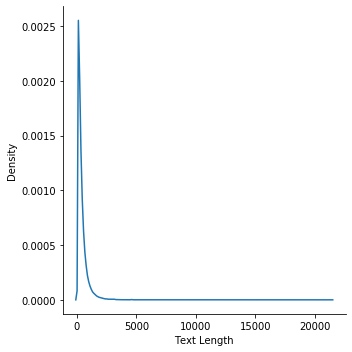

In [42]:
# Density plot of text length

import seaborn as sns  
import matplotlib.pyplot as plt
mydata = pd.read_pickle("mydata_model.pkl")

sns.displot(mydata['TextLength'], kind='kde')
plt.xlabel('Text Length')

Text(0.5, 6.79999999999999, 'Log Text Length')

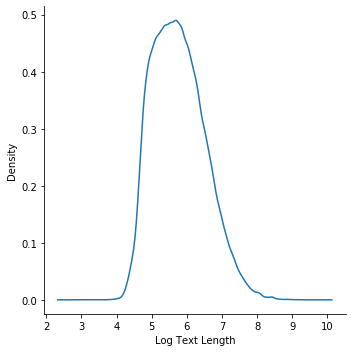

In [43]:
# log transformation to make it look like a normal distribution

from math import log

sns.displot(mydata['TextLength'].map(lambda x: log(x)), kind='kde')
plt.xlabel('Log Text Length')

In [44]:
# ols linear regression

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import confusion_matrix

#mydata['LogTextLength'] = mydata['TextLength'].map(lambda x: log(x))
#mydata.to_pickle("mydata_model_log.pkl")
mydata = pd.read_pickle('mydata_model_log.pkl')

y = mydata['Score']
x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']]

ols = LinearRegression()
ols.fit(x,y)
pred = ols.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using the whole dataset:', sqrt( mean_squared_error(y, pred) ))
print(confusion_matrix(y, pred))
print()

test = pd.read_csv('sampleSubmission.csv')
index = test['Id']
x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
pred = ols.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using those 100k data entries:', sqrt( mean_squared_error(y.loc[index], pred) )) 
print(confusion_matrix(y.loc[index], pred))

RMSE using the whole dataset: 1.1981281453940031
[[   668   9700  13568  25965   2367]
 [   138   2888   5887  18496   2360]
 [    97   2083   5815  29186   5459]
 [    80   1393   4812  53275  21095]
 [   280   3852  14516 196340 148134]]

RMSE using those 100k data entries: 1.199253934744431
[[  117  1693  2334  4682   405]
 [   31   531  1017  3228   419]
 [   19   399  1010  5102   911]
 [   20   226   830  9364  3763]
 [   53   660  2524 34661 26001]]


In [45]:
# LASSO
# Although the score on Kaggle is around 1.32681, something is wrong - everything is predicted to be 4

from sklearn.linear_model import Lasso

y = mydata['Score']
x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']]

lasso = Lasso() 
lasso.fit(x,y)
pred = lasso.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using the whole dataset:', sqrt( mean_squared_error(y, pred) ))
print(confusion_matrix(y, pred))
print()

test = pd.read_csv('sampleSubmission.csv')
index = test['Id']
x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
pred = lasso.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using those 100k data entries:', sqrt( mean_squared_error(y.loc[index], pred) )) 
print(confusion_matrix(y.loc[index], pred))

RMSE using the whole dataset: 1.3231784823473718
[[     0      0      0  52268      0]
 [     0      0      0  29769      0]
 [     0      0      0  42640      0]
 [     0      0      0  80655      0]
 [     0      0      0 363122      0]]

RMSE using those 100k data entries: 1.3240959179757334
[[    0     0     0  9231     0]
 [    0     0     0  5226     0]
 [    0     0     0  7441     0]
 [    0     0     0 14203     0]
 [    0     0     0 63899     0]]


In [46]:
print(lasso.coef_)
print(lasso.intercept_)
# a horizontal line with mean score as intercept

[-0.  0. -0.  0.]
4.183198640523243


In [47]:
# Ridge
# Similar result compared to ols model
from sklearn.linear_model import Ridge

y = mydata['Score']
x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']]

ridge = Ridge() 
ridge.fit(x,y)
pred = ridge.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using the whole dataset:', sqrt( mean_squared_error(y, pred) ))
print(confusion_matrix(y, pred))
print()

test = pd.read_csv('sampleSubmission.csv')
index = test['Id']
x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
pred = ridge.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using those 100k data entries:', sqrt( mean_squared_error(y.loc[index], pred) )) 
print(confusion_matrix(y.loc[index], pred))

RMSE using the whole dataset: 1.1981252088809835
[[   668   9700  13568  25965   2367]
 [   138   2888   5887  18496   2360]
 [    97   2083   5815  29186   5459]
 [    80   1393   4811  53276  21095]
 [   280   3852  14515 196341 148134]]

RMSE using those 100k data entries: 1.199237257593342
[[  117  1693  2334  4682   405]
 [   31   531  1017  3228   419]
 [   19   399  1010  5102   911]
 [   20   226   829  9365  3763]
 [   53   660  2523 34662 26001]]


In [48]:
# WLR - Give more weight to scores other than the mean (4) 
weights = np.ones(len(mydata))
weights[mydata[mydata['Score']!=4].index] *= 3

#y = pd.get_dummies(mydata['Score'])
y = mydata['Score']
x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']]

# fit the model
wlr = LinearRegression()
wlr.fit(x,y,weights)

#pred_array = wlr.predict(x)
#pred = []
#for i in range(len(pred_array)):
    #pred.append(pred_array[i].argmax() + 1)
pred = wlr.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using the whole dataset:', sqrt( mean_squared_error(y, pred) ))
print(confusion_matrix(y, pred))
print()

test = pd.read_csv('sampleSubmission.csv')
index = test['Id']
x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
pred = wlr.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using those 100k data entries:', sqrt( mean_squared_error(y.loc[index], pred) )) 
print(confusion_matrix(y.loc[index], pred))

RMSE using the whole dataset: 1.1969559046786906
[[  1367  10081  12846  24637   3337]
 [   338   3080   5689  17462   3200]
 [   187   2332   5646  27388   7087]
 [   160   1517   4820  48369  25789]
 [   502   4219  14612 171777 172012]]

RMSE using those 100k data entries: 1.1971257243915527
[[  243  1766  2208  4448   566]
 [   57   567   997  3049   556]
 [   35   443   975  4793  1195]
 [   32   254   821  8507  4589]
 [   92   731  2536 30306 30234]]


In [49]:
# Include helpfulness ratio?
import numpy as np

numerator = mydata['HelpfulnessNumerator'].to_numpy() 
denominator = mydata['HelpfulnessDenominator'].to_numpy() 
# data with 0 as denominator (270052 entries) will have a ratio of 0
ratio = np.divide(numerator,denominator, out=np.zeros(len(mydata)), where=denominator!=0)
mydata['Ratio'] = ratio
mydata.to_pickle('mydata_model_log_ratio.pkl')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001981BEA89C8>]],
      dtype=object)

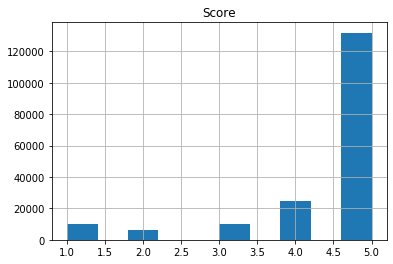

In [50]:
mydata[mydata['Ratio']==1].hist(column='Score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019877BD1708>]],
      dtype=object)

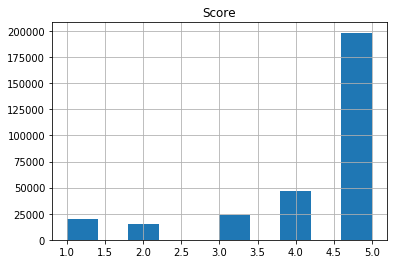

In [51]:
mydata[mydata['Ratio']==0].hist(column='Score') 
# Helpfulness ratio is not very useful

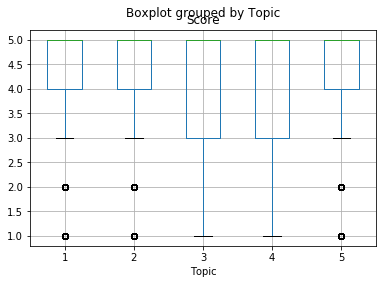

In [52]:
# Try to find what topics tend to have lower scores 
mydata.boxplot(by='Topic', column='Score') # I would try to group Topic 3 & topic 4 and also group the other three

In [53]:
# Try to find what products tend to have lower scores 
low_score_products = mydata[mydata['Score']<4]['ProductId'].unique()

In [ ]:
# *this code chunk will take a long time to run 
# Create a new variable grouping the topics
# Also create one more new variable indicating whether each data entry belongs to the low-score product group
topic_low = []
product_low = []
for i in range(len(mydata)):
    if mydata['Topic'][i] in [3,4]:
        topic_low.append(1)
    else:
        topic_low.append(0)
        
for i in range(len(mydata)):
    if mydata['ProductId'][i] in low_score_products:
        product_low.append(1)
    else:
        product_low.append(0)
mydata['Topic_group'] = topic_low
mydata['Product_group'] = product_low

In [ ]:
#mydata.to_pickle('grouped.pkl')

In [55]:
# ols2

mydata = pd.read_pickle('grouped.pkl')
y = mydata['Score']
x = mydata[['Topic_group','Product_group','CompoundScore','LogTextLength','EarlierThan2007']]

ols2 = LinearRegression()
ols2.fit(x,y)

# compute training rmse
pred = ols2.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using the whole dataset:', sqrt( mean_squared_error(y, pred) ))
print(confusion_matrix(y, pred))
print()

test = pd.read_csv('sampleSubmission.csv')
index = test['Id']
x = mydata[['Topic_group','Product_group','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
pred = ols2.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using those 100k data entries:', sqrt( mean_squared_error(y.loc[index], pred) )) 
print(confusion_matrix(y.loc[index], pred))

RMSE using the whole dataset: 1.175720806019889
[[   618  10217  14224  26455    754]
 [   138   2994   6399  19449    789]
 [    91   2252   6354  31848   2095]
 [    82   1320   4825  55445  18983]
 [   279   3521  14542 210088 134692]]

RMSE using those 100k data entries: 1.176660528784747
[[  114  1792  2454  4737   134]
 [   30   546  1117  3406   127]
 [   17   424  1108  5546   346]
 [   17   225   827  9716  3418]
 [   50   601  2540 37065 23643]]


In [56]:
# LASSO2 - same problem
y = mydata['Score']
x = mydata[['Topic_group','Product_group','CompoundScore','LogTextLength','EarlierThan2007']]

lasso2 = Lasso()
lasso2.fit(x,y)

# compute training rmse
pred = lasso2.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using the whole dataset:', sqrt( mean_squared_error(y, pred) ))
print(confusion_matrix(y, pred))
print()

test = pd.read_csv('sampleSubmission.csv')
index = test['Id']
x = mydata[['Topic_group','Product_group','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
pred = lasso2.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using those 100k data entries:', sqrt( mean_squared_error(y.loc[index], pred) )) 
print(confusion_matrix(y.loc[index], pred))

RMSE using the whole dataset: 1.3231784823473718
[[     0      0      0  52268      0]
 [     0      0      0  29769      0]
 [     0      0      0  42640      0]
 [     0      0      0  80655      0]
 [     0      0      0 363122      0]]

RMSE using those 100k data entries: 1.3240959179757334
[[    0     0     0  9231     0]
 [    0     0     0  5226     0]
 [    0     0     0  7441     0]
 [    0     0     0 14203     0]
 [    0     0     0 63899     0]]


In [57]:
# WLR2 - lowest RMSE :)
y = mydata['Score']
x = mydata[['Topic_group','Product_group','CompoundScore','LogTextLength','EarlierThan2007']]

weights = np.ones(len(mydata))
weights[mydata[mydata['Score']!=4].index] *= 3

# fit the model
wlr2 = LinearRegression()
wlr2.fit(x,y,weights)
pred = wlr2.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using the whole dataset:', sqrt( mean_squared_error(y, pred) ))
print(confusion_matrix(y, pred))
print()

test = pd.read_csv('sampleSubmission.csv')
index = test['Id']
x = mydata[['Topic_group','Product_group','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
pred = wlr2.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()
print('RMSE using those 100k data entries:', sqrt( mean_squared_error(y.loc[index], pred) )) 
print(confusion_matrix(y.loc[index], pred))

RMSE using the whole dataset: 1.170423413740071
[[  1338  10642  13410  25684   1194]
 [   308   3261   6139  18878   1183]
 [   174   2477   6222  30741   3026]
 [   138   1499   4798  52270  21950]
 [   487   3837  14519 191167 153112]]

RMSE using those 100k data entries: 1.1710977755934813
[[  243  1870  2298  4609   211]
 [   54   610  1065  3300   197]
 [   36   463  1078  5381   483]
 [   25   257   830  9159  3932]
 [   88   650  2544 33767 26850]]


## Test

In [ ]:
test = pd.read_csv('sampleSubmission.csv')
index = test['Id']
#x = mydata[['Topic','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
#x = newdata[['T1','T2','T3','T4','T5','CompoundScore','LogTextLength','NotEarlier','Earlier']].loc[index]
x = mydata[['Topic_group','Product_group','CompoundScore','LogTextLength','EarlierThan2007']].loc[index]
pred = wlr2.predict(x)
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1
    elif pred[i] > 5:
        pred[i] = 5
    else:
        pred[i] = pred[i].round()

test['Predicted'] = pred        
test.to_csv('Submission.csv', index=False)